In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv("/content/drive/MyDrive/STSbenchmark/input/train.csv")
data['score'] = data['score'] / 5.0 # normalize from 0 to 1
data.head(20)

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,1.0000,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,0.7600,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,0.7600,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,0.5200,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,0.8500,A man is playing the cello.,A man seated is playing the cello.
5,train,main-captions,MSRvid,2012test,11,0.8500,Some men are fighting.,Two men are fighting.
6,train,main-captions,MSRvid,2012test,12,0.1000,A man is smoking.,A man is skating.
7,train,main-captions,MSRvid,2012test,13,0.3200,The man is playing the piano.,The man is playing the guitar.
8,train,main-captions,MSRvid,2012test,14,0.4400,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,train,main-captions,MSRvid,2012test,16,1.0000,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [4]:
# Split the data into training and validation sets
train_data = data.sample(frac=0.8, random_state=42)
val_data = data.drop(train_data.index)

In [5]:
# Preprocess the data
sentences1 = train_data['sentence1'].values
sentences2 = train_data['sentence2'].values
labels = train_data['score'].values

In [6]:
# Tokenize the sentences and convert them to sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(np.concatenate((sentences1, sentences2), axis=0))
sequences1 = tokenizer.texts_to_sequences(sentences1)
sequences2 = tokenizer.texts_to_sequences(sentences2)

In [7]:
# Pad the sequences to have the same length
max_sequence_length = max(max(len(seq) for seq in sequences1), max(len(seq) for seq in sequences2))
padded_sequences1 = tf.keras.preprocessing.sequence.pad_sequences(sequences1, maxlen=max_sequence_length)
padded_sequences2 = tf.keras.preprocessing.sequence.pad_sequences(sequences2, maxlen=max_sequence_length)

In [8]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras import backend as K

def pearson_correlation_loss(x):
    # Compute the Pearson correlation coefficient between the input vectors
    x1_mean = K.mean(x[0], axis=1, keepdims=True)
    x2_mean = K.mean(x[1], axis=1, keepdims=True)
    x1_std = K.std(x[0], axis=1, keepdims=True)
    x2_std = K.std(x[1], axis=1, keepdims=True)
    covariance = K.mean((x[0] - x1_mean) * (x[1] - x2_mean), axis=1, keepdims=True)
    correlation = covariance / (x1_std * x2_std + K.epsilon())

    return correlation


def siamese_rnn(vocab_size, embedding_dim, max_sequence_length):
    # Shared embedding layer
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)

    # Shared LSTM layer
    lstm_layer = LSTM(128)

    # Input layers
    input_1 = Input(shape=(max_sequence_length,))
    input_2 = Input(shape=(max_sequence_length,))

    # Apply embedding and LSTM
    encoded_1 = embedding_layer(input_1)
    encoded_1 = lstm_layer(encoded_1)

    encoded_2 = embedding_layer(input_2)
    encoded_2 = lstm_layer(encoded_2)

    # Pearson correlation coefficient layer
    correlation = Lambda(pearson_correlation_loss)([encoded_1, encoded_2])

    # Create the model
    model = Model(inputs=[input_1, input_2], outputs=correlation)
    return model

In [9]:
# Create the Siamese RNN model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = siamese_rnn(vocab_size, embedding_dim, max_sequence_length)

In [10]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
batch_size = 64
epochs = 10
model.fit([padded_sequences1, padded_sequences2], labels,
          batch_size=batch_size, epochs=epochs)

Epoch 1/10
72/72 [==============================] - 37s 407ms/step - loss: 0.0755
Epoch 2/10
72/72 [==============================] - 25s 346ms/step - loss: 0.0286
Epoch 3/10
72/72 [==============================] - 20s 273ms/step - loss: 0.0192
Epoch 4/10
72/72 [==============================] - 24s 337ms/step - loss: 0.0140
Epoch 5/10
72/72 [==============================] - 21s 293ms/step - loss: 0.0110
Epoch 6/10
72/72 [==============================] - 19s 270ms/step - loss: 0.0096
Epoch 7/10
72/72 [==============================] - 21s 295ms/step - loss: 0.0081
Epoch 8/10
72/72 [==============================] - 19s 268ms/step - loss: 0.0068
Epoch 9/10
72/72 [==============================] - 19s 265ms/step - loss: 0.0061
Epoch 10/10
72/72 [==============================] - 20s 280ms/step - loss: 0.0055


In [11]:
def preprocess_text(text, tokenizer, max_sequence_length):
    # Apply any necessary preprocessing steps to the input text
    # For example, tokenization, padding, etc.
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_sequence_length)
    return padded_sequence

def predict_similarity(input_text_1, input_text_2, model, tokenizer, max_sequence_length, threshold):
    # Preprocess the input texts
    input_seq_1 = preprocess_text(input_text_1, tokenizer, max_sequence_length)
    input_seq_2 = preprocess_text(input_text_2, tokenizer, max_sequence_length)

    # Perform the prediction
    prediction = model.predict([input_seq_1, input_seq_2])

    # Compare the predicted similarity score to the threshold
    print("Similarity Score:", prediction[0][0])
    if prediction >= threshold:
        return "Similar"
    else:
        return "Dissimilar"

In [12]:
import sklearn.metrics
# Preprocess the validation data
val_sentences1 = val_data['sentence1'].values
val_sentences2 = val_data['sentence2'].values
val_labels = val_data['score'].values

val_sequences1 = tokenizer.texts_to_sequences(val_sentences1)
val_sequences2 = tokenizer.texts_to_sequences(val_sentences2)

val_padded_sequences1 = tf.keras.preprocessing.sequence.pad_sequences(val_sequences1, maxlen=max_sequence_length)
val_padded_sequences2 = tf.keras.preprocessing.sequence.pad_sequences(val_sequences2, maxlen=max_sequence_length)

# Iterate over different threshold values and evaluate F1 score on the validation set
threshold = 0.533
# scores=[]

# # Initialize counters for true positives, false positives, and false negatives
# true_positives = 0
# false_positives = 0
# false_negatives = 0

# y_pred_labels = []
# val_labels_binary = []
# fpr_list = []
# tpr_list = []

# # Make predictions and calculate true positives, false positives, and false negatives
# for i in range(len(val_data)):
#     prediction = predict_similarity(val_sentences1[i], val_sentences2[i], model, tokenizer, max_sequence_length, threshold)
#     prediction_label = 1 if prediction == "Similar" else 0

#     if prediction_label == 1 and val_labels[i] == 1:
#         true_positives += 1
#     elif prediction_label == 1 and val_labels[i] == 0:
#         false_positives += 1
#     elif prediction_label == 0 and val_labels[i] == 1:
#         false_negatives += 1

#     y_pred_labels.append(prediction_label)
#     val_labels_binary.append(1 if val_labels[i] >= threshold else 0)

# # Calculate Precision, Recall, and F1 Score
# precision = true_positives / (true_positives + false_positives + 1e-7)  # Add a small epsilon value to avoid division by zero
# recall = true_positives / (true_positives + false_negatives + 1e-7)
# f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
# scores.append(f1)

# y_pred = [predict_similarity(s1, s2, model, tokenizer, max_sequence_length, threshold) for s1, s2 in zip(val_sentences1, val_sentences2)]
# y_pred_labels = [1 if p == "Similar" else 0 for p in y_pred]
# val_labels_binary = [1 if score >= threshold else 0 for score in val_labels]

# # Calculate MCC using the current threshold
# mcc_score = sklearn.metrics.matthews_corrcoef(val_labels_binary, y_pred_labels)
# scores.append(mcc_score)

# # Calculate AUC using the current threshold
# fpr, tpr, _ = sklearn.metrics.roc_curve(val_labels_binary, y_pred_labels)
# fpr_list.append(fpr)
# tpr_list.append(tpr)
# auc_score = sklearn.metrics.auc(fpr, tpr)
# scores.append(auc_score)

# print(scores)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 60ms/step
Similarity Score: 0.3849098
1/1 [==============================] - 0s 93ms/step
Similarity Score: 0.9702832
1/1 [==============================] - 0s 90ms/step
Similarity Score: 0.60709614
1/1 [==============================] - 0s 50ms/step
Similarity Score: 0.87135315
1/1 [==============================] - 0s 39ms/step
Similarity Score: 0.9330224
1/1 [==============================] - 0s 37ms/step
Similarity Score: 0.3063764
1/1 [==============================] - 0s 39ms/step
Similarity Score: 0.99920297
1/1 [==============================] - 0s 40ms/step
Similarity Score: 0.71059036
1/1 [==============================] - 0s 34ms/step
Similarity Score: 0.7213141
1/1 [==============================] - 0s 39ms/step
Similarity Score: 0.18915148
1/1 [==============================] - 0s 37ms/step
Similarity Score: 0.5893135
1/1 [==============================] - 0s 36ms/step
Similarity S

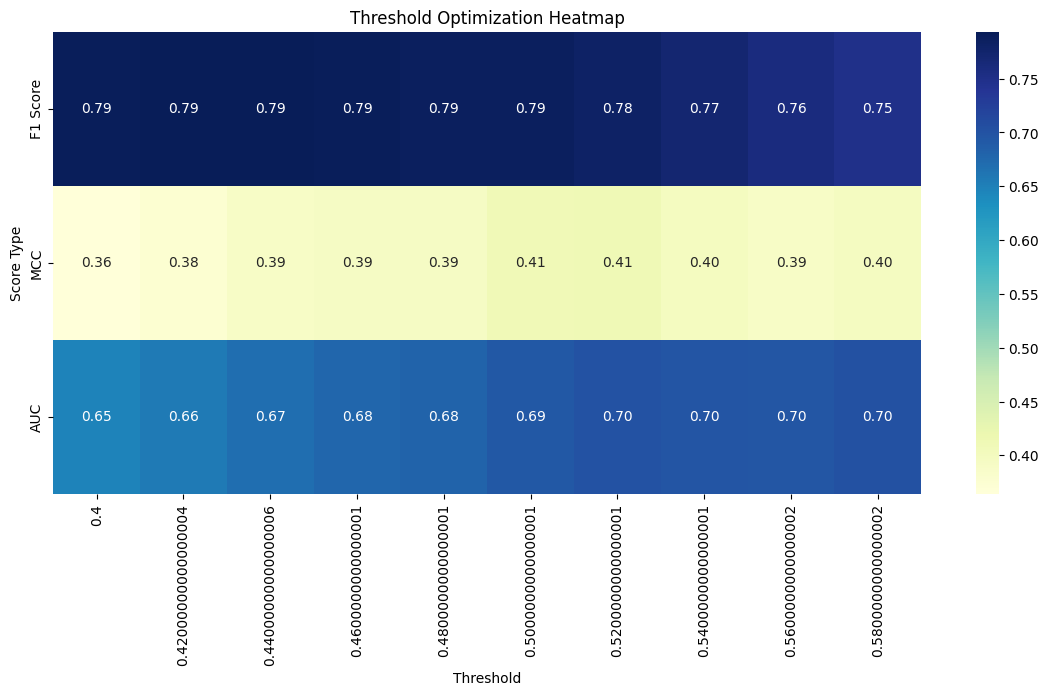

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define the range of threshold values to explore
thresholds = np.arange(0.4, 0.6, 0.02)
f1_scores = []
mcc_scores = []
auc_scores = []

# Iterate over different threshold values and evaluate scores on the validation set
for threshold in thresholds:
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    y_pred_labels = []
    val_labels_binary = []

    for i in range(len(val_data)):
        prediction = predict_similarity(val_sentences1[i], val_sentences2[i], model, tokenizer, max_sequence_length, threshold)
        prediction_label = 1 if prediction == "Similar" else 0

        if prediction_label == 1 and val_labels[i] >= 0.5:
            true_positives += 1
        elif prediction_label == 1 and val_labels[i] < 0.5:
            false_positives += 1
        elif prediction_label == 0 and val_labels[i] >= 0.5:
            false_negatives += 1

        y_pred_labels.append(prediction_label)
        val_labels_binary.append(1 if val_labels[i] >= 0.5 else 0)  # Adjust binary threshold if needed

    precision = true_positives / (true_positives + false_positives + 1e-7)  # Add a small epsilon value to avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    mcc = sklearn.metrics.matthews_corrcoef(val_labels_binary, y_pred_labels)
    fpr, tpr, _ = sklearn.metrics.roc_curve(val_labels_binary, y_pred_labels)
    auc = sklearn.metrics.auc(fpr, tpr)

    f1_scores.append(f1)
    mcc_scores.append(mcc)
    auc_scores.append(auc)

# Create a DataFrame for the heatmap
score_data = {
    "Threshold": thresholds,
    "F1 Score": f1_scores,
    "MCC": mcc_scores,
    "AUC": auc_scores,
}

df_scores = pd.DataFrame(score_data)

# Plotting the heatmap
plt.figure(figsize=(14, 6))
heatmap_data = df_scores.set_index("Threshold").T
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Threshold Optimization Heatmap")
plt.xlabel("Threshold")
plt.ylabel("Score Type")
plt.show()